<a href="https://colab.research.google.com/github/PiKaChu-wcg/pytorch/blob/main/SentimentAnalysis(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import json
import requests
import torch
import torch.nn as nn
import re 
import jieba
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
good_file='/content/drive/MyDrive/pytorch/good.txt'
bad_file='/content/drive/MyDrive/pytorch/bad.txt'
def filter_punc(sentence):
    sentence = re.sub("[\s+\.\!\/_,$%^*(+\"\'“”《》?“]+|[+——！，。？、~@#￥%……&*（）：]+", "", sentence)  
    return(sentence)
def Prepare_data(good_file,bad_file,is_filter=True):
    all_words=[]
    pos_sentences=[]
    neg_sentences=[]
    with open(good_file,'r',encoding='utf-8') as fr:
        for idx,line in enumerate(fr):
            if is_filter:
                line=filter_punc(line)
            words=jieba.lcut(line)
            if len(words):
                all_words+=words
                pos_sentences.append(words)
    print('{0}包含{1}行{2}个词'.format(good_file,idx+1,len(all_words)))
    count=len(all_words)
    with open(bad_file,'r',encoding='utf-8') as fr:
        for idx,line in enumerate(fr):
            if is_filter:
                line=filter_punc(line)
            words=jieba.lcut(line)
            if len(words):
                all_words+=words
                neg_sentences.append(words)
    print('{0}包含{1}行{2}个词'.format(bad_file,idx+1,len(all_words)-count))
    diction={}
    cnt=Counter(all_words)
    for word,freq in cnt.items():
        diction[word]=[len(diction),freq]
    print("{}".format(len(diction)))
    return(pos_sentences,neg_sentences,diction)
pos_sentences, neg_sentences, diction = Prepare_data(good_file, bad_file, False)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.943 seconds.
Prefix dict has been built successfully.


/content/drive/MyDrive/pytorch/good.txt包含8089行136359个词
/content/drive/MyDrive/pytorch/bad.txt包含5076行75600个词
7029


In [8]:
def word2idx(word,diction):
    if word in diction:
        value=diction[word][0]
    else:
        value=-1
    return value
def idx2word(idx,diction):
    for w,v in diction.items():
        if v[0]==idx:
            return(w)
    return(None)
def sentence2vec(sentence,diction):
    vector=np.zeros(len(diction))
    for l in sentence:
        vector[l]+=1
    return(1.0*vector/len(sentence))

In [9]:
# 重新准备数据，输入给RNN
# 与词袋模型不同的是。每一个句子在词袋模型中都被表示为了固定长度的向量，其中长度为字典的尺寸
# 在RNN中，每一个句子就是被单独当成词语的序列来处理的，因此序列的长度是与句子等长的

dataset = []
labels = []
sentences = []

# 正例集合
for sentence in pos_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            # 注意将每个词编码
            new_sentence.append(word2idx(l, diction))
    #每一个句子都是一个不等长的整数序列
    dataset.append(new_sentence)
    labels.append(0)
    sentences.append(sentence)

# 反例集合
for sentence in neg_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2idx(l, diction))
    dataset.append(new_sentence)
    labels.append(1)
    sentences.append(sentence)

# 重新对数据洗牌，构造数据集合
indices = np.random.permutation(len(dataset))
dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]
sentences = [sentences[i] for i in indices]

test_size = len(dataset) // 10

# 训练集
train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

# 校验集
valid_data = dataset[: test_size]
valid_label = labels[: test_size]

# 测试集
test_data = dataset[test_size : 2 * test_size]
test_label = labels[test_size : 2 * test_size]


In [33]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN, self).__init__()
        self.hidden_size=hidden_size
        self.embed=nn.Embedding(input_size,hidden_size)
        self.i2h=nn.Linear(2*hidden_size,hidden_size)
        self.i2o=nn.Linear(hidden_size,output_size)
        self.softmax=nn.LogSoftmax()
    def forward(self,input,hidden):
        x=self.embed(input)
        combined=torch.cat((x,hidden),1)
        hidden=self.i2h(combined)
        output=self.i2o(hidden)
        output=self.softmax(output)
        return output,hidden
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)

rnn=RNN(len(diction),10,2)
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

In [34]:

cost=torch.nn.NLLLoss()
optimizer=torch.optim.Adam(rnn.parameters(),lr=0.001)
records=[]
losses=[]
for epoch in range(10):
    for i,data in enumerate(zip(train_data,train_label)):
        x,y=data
        x=torch.tensor(x,dtype=torch.long).unsqueeze(1)
        y=torch.tensor(np.array([y]),dtype=torch.long)
        optimizer.zero_grad()
        hidden=rnn.initHidden()
        for s in range(x.size()[0]):
            output,hidden=rnn(x[s],hidden)
        loss=cost(output,y)
        losses.append(loss.data.numpy())
        loss.backward()
        optimizer.step()
        if i % 3000 == 0:
            # 每间隔3000步来一次校验集上面的计算
            val_losses = []
            rights = []
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = torch.tensor(x, dtype = torch.long).unsqueeze(1)
                y = torch.tensor(np.array([y]), dtype = torch.long)
                hidden = rnn.initHidden()
                for s in range(x.size()[0]):
                    output, hidden = rnn(x[s], hidden)
                right = rightness(output, y)
                rights.append(right)
                loss = cost(output, y)
                val_losses.append(loss.data.numpy())
            # 计算准确度
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 测试损失：{:.2f}, 测试准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


第0轮，训练损失：1.33, 测试损失：0.93, 测试准确率: 0.37
第0轮，训练损失：0.56, 测试损失：0.47, 测试准确率: 0.80
第0轮，训练损失：0.48, 测试损失：0.37, 测试准确率: 0.86
第0轮，训练损失：0.44, 测试损失：0.33, 测试准确率: 0.88
第1轮，训练损失：0.43, 测试损失：0.32, 测试准确率: 0.89
第1轮，训练损失：0.41, 测试损失：0.32, 测试准确率: 0.90
第1轮，训练损失：0.39, 测试损失：0.31, 测试准确率: 0.89
第1轮，训练损失：0.38, 测试损失：0.29, 测试准确率: 0.90
第2轮，训练损失：0.37, 测试损失：0.29, 测试准确率: 0.91
第2轮，训练损失：0.36, 测试损失：0.29, 测试准确率: 0.90
第2轮，训练损失：0.35, 测试损失：0.29, 测试准确率: 0.90
第2轮，训练损失：0.34, 测试损失：0.28, 测试准确率: 0.91
第3轮，训练损失：0.34, 测试损失：0.28, 测试准确率: 0.90
第3轮，训练损失：0.34, 测试损失：0.29, 测试准确率: 0.91
第3轮，训练损失：0.33, 测试损失：0.29, 测试准确率: 0.90
第3轮，训练损失：0.32, 测试损失：0.28, 测试准确率: 0.91
第4轮，训练损失：0.32, 测试损失：0.28, 测试准确率: 0.90
第4轮，训练损失：0.32, 测试损失：0.28, 测试准确率: 0.91
第4轮，训练损失：0.31, 测试损失：0.29, 测试准确率: 0.90
第4轮，训练损失：0.31, 测试损失：0.28, 测试准确率: 0.91
第5轮，训练损失：0.31, 测试损失：0.28, 测试准确率: 0.91
第5轮，训练损失：0.30, 测试损失：0.28, 测试准确率: 0.91
第5轮，训练损失：0.30, 测试损失：0.28, 测试准确率: 0.90
第5轮，训练损失：0.30, 测试损失：0.27, 测试准确率: 0.91
第6轮，训练损失：0.30, 测试损失：0.28, 测试准确率: 0.91
第6轮，训练损失：0.29, 测试损失：0.28, 测试准确率: 0.91
第6轮，训练损失：0.2

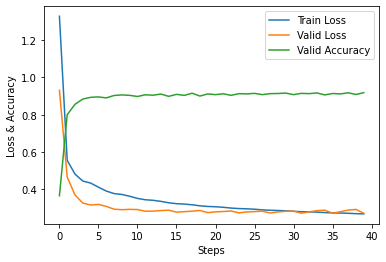

In [35]:
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

In [37]:
#在测试
vals = [] #记录准确率所用列表
rights = []
#对测试数据集进行循环
for j, test in enumerate(zip(test_data, test_label)):
    x, y = test
    x = torch.LongTensor(x).unsqueeze(1)
    y = torch.LongTensor(np.array([y]))
    hidden = rnn.initHidden()
    for s in range(x.size()[0]):
        output, hidden = rnn(x[s], hidden)
    right = rightness(output, y)
    rights.append(right)
    val = rightness(output, y) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].data.numpy() / rights[1]
right_rate

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


0.9179331306990881

In [38]:
torch.save(rnn, 'rnn.mdl')